In [1]:
import copy
import math
import os
import warnings
from typing import Optional, Tuple, Union

import torch
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.utils.checkpoint import checkpoint

In [2]:
def load_tf_weights_in_t5(model, tf_checkpoint_path):
    """Load tf checkpoints in a pytorch model."""
    try:
        import re

        import numpy as np
        import tensorflow as tf
    except ImportError:
        logger.error(
            "Loading a TensorFlow model in PyTorch, requires TensorFlow to be installed. Please see "
            "https://www.tensorflow.org/install/ for installation instructions."
        )
        raise
    tf_path = os.path.abspath(tf_checkpoint_path)
    logger.info(f"Converting TensorFlow checkpoint from {tf_path}")
    # Load weights from TF model
    init_vars = tf.train.list_variables(tf_path)
    names = []
    tf_weights = {}
    for name, shape in init_vars:
        logger.info(f"Loading TF weight {name} with shape {shape}")
        array = tf.train.load_variable(tf_path, name)
        names.append(name)
        tf_weights[name] = array

    for txt_name in names:
        name = txt_name.split("/")
        # adam_v and adam_m are variables used in AdamWeightDecayOptimizer to calculated m and v
        # which are not required for using pretrained model
        if any(
            n in ["adam_v", "adam_m", "AdamWeightDecayOptimizer", "AdamWeightDecayOptimizer_1", "global_step"]
            for n in name
        ):
            logger.info(f"Skipping {'/'.join(name)}")
            tf_weights.pop(txt_name, None)
            continue
        if "_slot_" in name[-1]:
            logger.info(f"Skipping {'/'.join(name)}")
            tf_weights.pop(txt_name, None)
            continue
        pointer = model
        array = tf_weights[txt_name]

        for m_name in name:
            if re.fullmatch(r"[A-Za-z]+_\d+", m_name):
                scope_names = re.split(r"_(\d+)", m_name)
            else:
                scope_names = [m_name]
            if scope_names[0] in ["kernel", "scale", "embedding"]:
                pointer = getattr(pointer, "weight")
            elif scope_names[0] == "self_attention":
                pointer = getattr(pointer, "layer")
                pointer = pointer[0]
            elif scope_names[0] == "enc_dec_attention":
                pointer = getattr(pointer, "layer")
                pointer = pointer[1]
            elif scope_names[0] == "dense_relu_dense":
                pointer = getattr(pointer, "layer")
                pointer = pointer[2]
            elif scope_names[0] == "rms_norm":
                if hasattr(pointer, "layer_norm"):
                    pointer = getattr(pointer, "layer_norm")
                elif hasattr(pointer, "final_layer_norm"):
                    pointer = getattr(pointer, "final_layer_norm")
            elif scope_names[0] == "scale":
                pointer = getattr(pointer, "weight")
            elif scope_names[0] == "output_bias" or scope_names[0] == "beta":
                pointer = getattr(pointer, "bias")
            elif scope_names[0] == "squad":
                pointer = getattr(pointer, "classifier")
            elif scope_names[0] == "decoder" and name[1] == "logits":
                continue
            elif scope_names[0] == "logits":
                pointer = getattr(pointer, "lm_head")
            elif scope_names[0] == "wi" and len(scope_names) > 1 and scope_names[1].isdigit():
                pointer = getattr(pointer, f"wi_{scope_names[1]}")
                continue
            else:
                try:
                    pointer = getattr(pointer, scope_names[0])
                except AttributeError:
                    logger.info(f"Skipping {'/'.join(name)}")
                    continue
            if len(scope_names) >= 2:
                num = int(scope_names[1])
                pointer = pointer[num]
        if scope_names[0] not in ["kernel", "scale", "embedding"]:
            pointer = getattr(pointer, "weight")
        if scope_names[0] != "embedding":
            logger.info(f"Transposing numpy weight of shape {array.shape} for {name}")
            array = np.transpose(array)
        try:
            assert (
                pointer.shape == array.shape
            ), f"Pointer shape {pointer.shape} and array shape {array.shape} mismatched"
        except AssertionError as e:
            e.args += (pointer.shape, array.shape)
            raise
        logger.info(f"Initialize PyTorch weight {name}")
        pointer.data = torch.from_numpy(array.astype(np.float32))
        tf_weights.pop(txt_name, None)

    logger.info(f"Weights not copied to PyTorch model: {', '.join(tf_weights.keys())}.")
    return model

In [3]:
class T5LayerNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-6):
        """
        Construct a layernorm module in the T5 style. No bias and no subtraction of mean.
        """
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.variance_epsilon = eps

    def forward(self, hidden_states):
        # T5 uses a layer_norm which only scales and doesn't shift, which is also known as Root Mean
        # Square Layer Normalization https://arxiv.org/abs/1910.07467 thus varience is calculated
        # w/o mean and there is no bias. Additionally we want to make sure that the accumulation for
        # half-precision inputs is done in fp32

        variance = hidden_states.to(torch.float32).pow(2).mean(-1, keepdim=True)
        hidden_states = hidden_states * torch.rsqrt(variance + self.variance_epsilon)

        # convert into half-precision if necessary
        if self.weight.dtype in [torch.float16, torch.bfloat16]:
            hidden_states = hidden_states.to(self.weight.dtype)

        return self.weight * hidden_states


In [4]:
class T5DenseActDense(nn.Module):
    def __init__(self, d_model, d_ff, dropout_rate):
        super().__init__()
        self.wi = nn.Linear(d_model, d_ff, bias=False)
        self.wo = nn.Linear(d_ff, d_model, bias=False)
        self.dropout = nn.Dropout(dropout_rate)
        self.act = nn.GELU()

    def forward(self, hidden_states):
        hidden_states = self.wi(hidden_states)
        hidden_states = self.act(hidden_states)
        hidden_states = self.dropout(hidden_states)
        if (
            isinstance(self.wo.weight, torch.Tensor)
            and hidden_states.dtype != self.wo.weight.dtype
            and self.wo.weight.dtype != torch.int8
        ):
            hidden_states = hidden_states.to(self.wo.weight.dtype)
        hidden_states = self.wo(hidden_states)
        return hidden_states

In [5]:
class T5DenseGatedActDense(nn.Module):
    def __init__(self, d_model, d_ff, dropout_rate):
        super().__init__()
        self.wi_0 = nn.Linear(d_model, d_ff, bias=False)
        self.wi_1 = nn.Linear(d_model, d_ff, bias=False)
        self.wo = nn.Linear(d_ff, d_model, bias=False)
        self.dropout = nn.Dropout(dropout_rate)
        self.act = nn.GELU()

    def forward(self, hidden_states):
        hidden_gelu = self.act(self.wi_0(hidden_states))
        hidden_linear = self.wi_1(hidden_states)
        hidden_states = hidden_gelu * hidden_linear
        hidden_states = self.dropout(hidden_states)

        # To make 8bit quantization work for google/flan-t5-xxl, self.wo is kept in float32.
        # See https://github.com/huggingface/transformers/issues/20287
        # we also make sure the weights are not in `int8` in case users will force `_keep_in_fp32_modules` to be `None``
        if (
            isinstance(self.wo.weight, torch.Tensor)
            and hidden_states.dtype != self.wo.weight.dtype
            and self.wo.weight.dtype != torch.int8
        ):
            hidden_states = hidden_states.to(self.wo.weight.dtype)

        hidden_states = self.wo(hidden_states)
        return hidden_states

In [6]:
class T5LayerFF(nn.Module):
    def __init__(self, d_model, d_ff, dropout_rate, layer_norm_epsilon=1e-6, 
                 is_gated_act=True):
        super().__init__()
        if is_gated_act:
            self.DenseReluDense = T5DenseGatedActDense(d_model, d_ff, dropout_rate)
        else:
            self.DenseReluDense = T5DenseActDense(d_model, d_ff, dropout_rate)

        self.layer_norm = T5LayerNorm(d_model, eps=layer_norm_epsilon)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, hidden_states):
        forwarded_states = self.layer_norm(hidden_states)
        forwarded_states = self.DenseReluDense(forwarded_states)
        hidden_states = hidden_states + self.dropout(forwarded_states)
        return hidden_states

In [7]:
class T5Attention(nn.Module):
    def __init__(self, d_model, num_heads, d_kv, dropout_rate, relative_attention_num_buckets, 
                 relative_attention_max_distance, is_decoder, has_relative_attention_bias=False):
        super().__init__()
        self.is_decoder = is_decoder
        self.has_relative_attention_bias = has_relative_attention_bias
        self.relative_attention_num_buckets = relative_attention_num_buckets
        self.relative_attention_max_distance = relative_attention_max_distance
        self.d_model = d_model
        self.key_value_proj_dim = d_kv
        self.n_heads = num_heads
        self.dropout = dropout_rate
        self.inner_dim = self.n_heads * self.key_value_proj_dim

        # Mesh TensorFlow initialization to avoid scaling before softmax
        self.q = nn.Linear(self.d_model, self.inner_dim, bias=False)
        self.k = nn.Linear(self.d_model, self.inner_dim, bias=False)
        self.v = nn.Linear(self.d_model, self.inner_dim, bias=False)
        self.o = nn.Linear(self.inner_dim, self.d_model, bias=False)

        if self.has_relative_attention_bias:
            self.relative_attention_bias = nn.Embedding(self.relative_attention_num_buckets, self.n_heads)
        self.pruned_heads = set()
        self.gradient_checkpointing = False

    def prune_heads(self, heads):
        if len(heads) == 0:
            return
        heads, index = find_pruneable_heads_and_indices(
            heads, self.n_heads, self.key_value_proj_dim, self.pruned_heads
        )
        # Prune linear layers
        self.q = prune_linear_layer(self.q, index)
        self.k = prune_linear_layer(self.k, index)
        self.v = prune_linear_layer(self.v, index)
        self.o = prune_linear_layer(self.o, index, dim=1)
        # Update hyper params
        self.n_heads = self.n_heads - len(heads)
        self.inner_dim = self.key_value_proj_dim * self.n_heads
        self.pruned_heads = self.pruned_heads.union(heads)

    @staticmethod
    def _relative_position_bucket(relative_position, bidirectional=True, num_buckets=32, max_distance=128):
        """
        Adapted from Mesh Tensorflow:
        https://github.com/tensorflow/mesh/blob/0cb87fe07da627bf0b7e60475d59f95ed6b5be3d/mesh_tensorflow/transformer/transformer_layers.py#L593
        Translate relative position to a bucket number for relative attention. The relative position is defined as
        memory_position - query_position, i.e. the distance in tokens from the attending position to the attended-to
        position. If bidirectional=False, then positive relative positions are invalid. We use smaller buckets for
        small absolute relative_position and larger buckets for larger absolute relative_positions. All relative
        positions >=max_distance map to the same bucket. All relative positions <=-max_distance map to the same bucket.
        This should allow for more graceful generalization to longer sequences than the model has been trained on
        Args:
            relative_position: an int32 Tensor
            bidirectional: a boolean - whether the attention is bidirectional
            num_buckets: an integer
            max_distance: an integer
        Returns:
            a Tensor with the same shape as relative_position, containing int32 values in the range [0, num_buckets)
        """
        relative_buckets = 0
        if bidirectional:
            num_buckets //= 2
            relative_buckets += (relative_position > 0).to(torch.long) * num_buckets
            relative_position = torch.abs(relative_position)
        else:
            relative_position = -torch.min(relative_position, torch.zeros_like(relative_position))
        # now relative_position is in the range [0, inf)

        # half of the buckets are for exact increments in positions
        max_exact = num_buckets // 2
        is_small = relative_position < max_exact

        # The other half of the buckets are for logarithmically bigger bins in positions up to max_distance
        relative_position_if_large = max_exact + (
            torch.log(relative_position.float() / max_exact)
            / math.log(max_distance / max_exact)
            * (num_buckets - max_exact)
        ).to(torch.long)
        relative_position_if_large = torch.min(
            relative_position_if_large, torch.full_like(relative_position_if_large, num_buckets - 1)
        )

        relative_buckets += torch.where(is_small, relative_position, relative_position_if_large)
        return relative_buckets

    def compute_bias(self, query_length, key_length, device=None):
        """Compute binned relative position bias"""
        if device is None:
            device = self.relative_attention_bias.weight.device
        context_position = torch.arange(query_length, dtype=torch.long, device=device)[:, None]
        memory_position = torch.arange(key_length, dtype=torch.long, device=device)[None, :]
        relative_position = memory_position - context_position  # shape (query_length, key_length)
        relative_position_bucket = self._relative_position_bucket(
            relative_position,  # shape (query_length, key_length)
            bidirectional=(not self.is_decoder),
            num_buckets=self.relative_attention_num_buckets,
            max_distance=self.relative_attention_max_distance,
        )
        values = self.relative_attention_bias(relative_position_bucket)  # shape (query_length, key_length, num_heads)
        values = values.permute([2, 0, 1]).unsqueeze(0)  # shape (1, num_heads, query_length, key_length)
        return values

    def forward(
        self,
        hidden_states,
        mask=None,
        key_value_states=None,
        position_bias=None,
        past_key_value=None,
        layer_head_mask=None,
        query_length=None,
        use_cache=False,
        output_attentions=False,
    ):
        """
        Self-attention (if key_value_states is None) or attention over source sentence (provided by key_value_states).
        """
        # Input is (batch_size, seq_length, dim)
        # Mask is (batch_size, key_length) (non-causal) or (batch_size, key_length, key_length)
        # past_key_value[0] is (batch_size, n_heads, q_len - 1, dim_per_head)
        batch_size, seq_length = hidden_states.shape[:2]

        real_seq_length = seq_length

        if past_key_value is not None:
            assert (
                len(past_key_value) == 2
            ), f"past_key_value should have 2 past states: keys and values. Got { len(past_key_value)} past states"
            real_seq_length += past_key_value[0].shape[2] if query_length is None else query_length

        key_length = real_seq_length if key_value_states is None else key_value_states.shape[1]

        def shape(states):
            """projection"""
            return states.view(batch_size, -1, self.n_heads, self.key_value_proj_dim).transpose(1, 2)

        def unshape(states):
            """reshape"""
            return states.transpose(1, 2).contiguous().view(batch_size, -1, self.inner_dim)

        def project(hidden_states, proj_layer, key_value_states, past_key_value):
            """projects hidden states correctly to key/query states"""
            if key_value_states is None:
                # self-attn
                # (batch_size, n_heads, seq_length, dim_per_head)
                hidden_states = shape(proj_layer(hidden_states))
            elif past_key_value is None:
                # cross-attn
                # (batch_size, n_heads, seq_length, dim_per_head)
                hidden_states = shape(proj_layer(key_value_states))

            if past_key_value is not None:
                if key_value_states is None:
                    # self-attn
                    # (batch_size, n_heads, key_length, dim_per_head)
                    hidden_states = torch.cat([past_key_value, hidden_states], dim=2)
                elif past_key_value.shape[2] != key_value_states.shape[1]:
                    # checking that the `sequence_length` of the `past_key_value` is the same as
                    # the provided `key_value_states` to support prefix tuning
                    # cross-attn
                    # (batch_size, n_heads, seq_length, dim_per_head)
                    hidden_states = shape(proj_layer(key_value_states))
                else:
                    # cross-attn
                    hidden_states = past_key_value
            return hidden_states

        # get query states
        query_states = shape(self.q(hidden_states))  # (batch_size, n_heads, seq_length, dim_per_head)

        # get key/value states
        key_states = project(
            hidden_states, self.k, key_value_states, past_key_value[0] if past_key_value is not None else None
        )
        value_states = project(
            hidden_states, self.v, key_value_states, past_key_value[1] if past_key_value is not None else None
        )

        # compute scores
        scores = torch.matmul(
            query_states, key_states.transpose(3, 2)
        )  # equivalent of torch.einsum("bnqd,bnkd->bnqk", query_states, key_states), compatible with onnx op>9

        if position_bias is None:
            if not self.has_relative_attention_bias:
                position_bias = torch.zeros(
                    (1, self.n_heads, real_seq_length, key_length), device=scores.device, dtype=scores.dtype
                )
                if self.gradient_checkpointing and self.training:
                    position_bias.requires_grad = True
            else:
                position_bias = self.compute_bias(real_seq_length, key_length, device=scores.device)

            # if key and values are already calculated
            # we want only the last query position bias
            if past_key_value is not None:
                position_bias = position_bias[:, :, -hidden_states.size(1) :, :]

            if mask is not None:
                position_bias = position_bias + mask  # (batch_size, n_heads, seq_length, key_length)

        if self.pruned_heads:
            mask = torch.ones(position_bias.shape[1])
            mask[list(self.pruned_heads)] = 0
            position_bias_masked = position_bias[:, mask.bool()]
        else:
            position_bias_masked = position_bias

        scores += position_bias_masked
        attn_weights = nn.functional.softmax(scores.float(), dim=-1).type_as(
            scores
        )  # (batch_size, n_heads, seq_length, key_length)
        attn_weights = nn.functional.dropout(
            attn_weights, p=self.dropout, training=self.training
        )  # (batch_size, n_heads, seq_length, key_length)

        # Mask heads if we want to
        if layer_head_mask is not None:
            attn_weights = attn_weights * layer_head_mask

        attn_output = unshape(torch.matmul(attn_weights, value_states))  # (batch_size, seq_length, dim)
        attn_output = self.o(attn_output)

        present_key_value_state = (key_states, value_states) if (self.is_decoder and use_cache) else None
        outputs = (attn_output,) + (present_key_value_state,) + (position_bias,)

        if output_attentions:
            outputs = outputs + (attn_weights,)
        return outputs

In [8]:
class T5LayerSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads, d_kv, dropout_rate, relative_attention_num_buckets, 
                 relative_attention_max_distance, is_decoder, layer_norm_epsilon=1e-6, has_relative_attention_bias=False):
        super().__init__()
        self.SelfAttention = T5Attention(d_model, num_heads, d_kv, dropout_rate, relative_attention_num_buckets, 
                 relative_attention_max_distance, is_decoder, has_relative_attention_bias)
        self.layer_norm = T5LayerNorm(d_model, eps=layer_norm_epsilon)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        position_bias=None,
        layer_head_mask=None,
        past_key_value=None,
        use_cache=False,
        output_attentions=False,
    ):
        normed_hidden_states = self.layer_norm(hidden_states)
        attention_output = self.SelfAttention(
            normed_hidden_states,
            mask=attention_mask,
            position_bias=position_bias,
            layer_head_mask=layer_head_mask,
            past_key_value=past_key_value,
            use_cache=use_cache,
            output_attentions=output_attentions,
        )
        hidden_states = hidden_states + self.dropout(attention_output[0])
        outputs = (hidden_states,) + attention_output[1:]  # add attentions if we output them
        return outputs

In [9]:
class T5LayerCrossAttention(nn.Module):
    def __init__(self, d_model, num_heads, d_kv, dropout_rate, relative_attention_num_buckets, 
                 relative_attention_max_distance, is_decoder, layer_norm_epsilon=1e-6, has_relative_attention_bias=False):
        super().__init__()
        self.EncDecAttention = T5Attention(d_model, num_heads, d_kv, dropout_rate, relative_attention_num_buckets, 
                 relative_attention_max_distance, is_decoder, has_relative_attention_bias)
        self.layer_norm = T5LayerNorm(d_model, eps=layer_norm_epsilon)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(
        self,
        hidden_states,
        key_value_states,
        attention_mask=None,
        position_bias=None,
        layer_head_mask=None,
        past_key_value=None,
        use_cache=False,
        query_length=None,
        output_attentions=False,
    ):
        normed_hidden_states = self.layer_norm(hidden_states)
        attention_output = self.EncDecAttention(
            normed_hidden_states,
            mask=attention_mask,
            key_value_states=key_value_states,
            position_bias=position_bias,
            layer_head_mask=layer_head_mask,
            past_key_value=past_key_value,
            use_cache=use_cache,
            query_length=query_length,
            output_attentions=output_attentions,
        )
        layer_output = hidden_states + self.dropout(attention_output[0])
        outputs = (layer_output,) + attention_output[1:]  # add attentions if we output them
        return outputs

In [10]:
class T5Block(nn.Module):
    def __init__(self, d_model, d_ff, num_heads, d_kv, dropout_rate, relative_attention_num_buckets, 
                 relative_attention_max_distance, is_decoder, layer_norm_epsilon=1e-6, is_gated_act=True, 
                 has_relative_attention_bias=False):
        super().__init__()
        self.is_decoder = is_decoder
        self.layer = nn.ModuleList()
        self.layer.append(T5LayerSelfAttention(d_model, num_heads, d_kv, dropout_rate, relative_attention_num_buckets, 
                 relative_attention_max_distance, is_decoder, layer_norm_epsilon, has_relative_attention_bias))
        if self.is_decoder:
            self.layer.append(T5LayerCrossAttention(d_model, num_heads, d_kv, dropout_rate, relative_attention_num_buckets, 
                 relative_attention_max_distance, is_decoder, layer_norm_epsilon, has_relative_attention_bias))

        self.layer.append(T5LayerFF(d_model, d_ff, dropout_rate, layer_norm_epsilon, is_gated_act))

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        position_bias=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        encoder_decoder_position_bias=None,
        layer_head_mask=None,
        cross_attn_layer_head_mask=None,
        past_key_value=None,
        use_cache=False,
        output_attentions=False,
        return_dict=True,
    ):
        if past_key_value is not None:
            if not self.is_decoder:
                logger.warning("`past_key_values` is passed to the encoder. Please make sure this is intended.")
            expected_num_past_key_values = 2 if encoder_hidden_states is None else 4

            if len(past_key_value) != expected_num_past_key_values:
                raise ValueError(
                    f"There should be {expected_num_past_key_values} past states. "
                    f"{'2 (past / key) for cross attention. ' if expected_num_past_key_values == 4 else ''}"
                    f"Got {len(past_key_value)} past key / value states"
                )

            self_attn_past_key_value = past_key_value[:2]
            cross_attn_past_key_value = past_key_value[2:]
        else:
            self_attn_past_key_value, cross_attn_past_key_value = None, None

        self_attention_outputs = self.layer[0](
            hidden_states,
            attention_mask=attention_mask,
            position_bias=position_bias,
            layer_head_mask=layer_head_mask,
            past_key_value=self_attn_past_key_value,
            use_cache=use_cache,
            output_attentions=output_attentions,
        )
        hidden_states, present_key_value_state = self_attention_outputs[:2]
        attention_outputs = self_attention_outputs[2:]  # Keep self-attention outputs and relative position weights

        # clamp inf values to enable fp16 training
        if hidden_states.dtype == torch.float16:
            clamp_value = torch.where(
                torch.isinf(hidden_states).any(),
                torch.finfo(hidden_states.dtype).max - 1000,
                torch.finfo(hidden_states.dtype).max,
            )
            hidden_states = torch.clamp(hidden_states, min=-clamp_value, max=clamp_value)

        do_cross_attention = self.is_decoder and encoder_hidden_states is not None
        if do_cross_attention:
            # the actual query length is unknown for cross attention
            # if using past key value states. Need to inject it here
            if present_key_value_state is not None:
                query_length = present_key_value_state[0].shape[2]
            else:
                query_length = None

            cross_attention_outputs = self.layer[1](
                hidden_states,
                key_value_states=encoder_hidden_states,
                attention_mask=encoder_attention_mask,
                position_bias=encoder_decoder_position_bias,
                layer_head_mask=cross_attn_layer_head_mask,
                past_key_value=cross_attn_past_key_value,
                query_length=query_length,
                use_cache=use_cache,
                output_attentions=output_attentions,
            )
            hidden_states = cross_attention_outputs[0]

            # clamp inf values to enable fp16 training
            if hidden_states.dtype == torch.float16:
                clamp_value = torch.where(
                    torch.isinf(hidden_states).any(),
                    torch.finfo(hidden_states.dtype).max - 1000,
                    torch.finfo(hidden_states.dtype).max,
                )
                hidden_states = torch.clamp(hidden_states, min=-clamp_value, max=clamp_value)

            # Combine self attn and cross attn key value states
            if present_key_value_state is not None:
                present_key_value_state = present_key_value_state + cross_attention_outputs[1]

            # Keep cross-attention outputs and relative position weights
            attention_outputs = attention_outputs + cross_attention_outputs[2:]

        # Apply Feed Forward layer
        hidden_states = self.layer[-1](hidden_states)

        # clamp inf values to enable fp16 training
        if hidden_states.dtype == torch.float16:
            clamp_value = torch.where(
                torch.isinf(hidden_states).any(),
                torch.finfo(hidden_states.dtype).max - 1000,
                torch.finfo(hidden_states.dtype).max,
            )
            hidden_states = torch.clamp(hidden_states, min=-clamp_value, max=clamp_value)

        outputs = (hidden_states,)

        if use_cache:
            outputs = outputs + (present_key_value_state,) + attention_outputs
        else:
            outputs = outputs + attention_outputs

        return outputs

In [11]:
class T5Stack(nn.Module):
    def __init__(self, num_layers, d_model, d_ff, num_heads, d_kv, dropout_rate, relative_attention_num_buckets, 
                 relative_attention_max_distance, is_decoder, use_cache, output_attentions, output_hidden_states, 
                 use_return_dict, layer_norm_epsilon=1e-6, is_gated_act=True, has_relative_attention_bias=False, 
                 embed_tokens=None):
        super().__init__()

        self.embed_tokens = embed_tokens
        self.is_decoder = is_decoder

        self.block = nn.ModuleList(
            [T5Block(d_model, d_ff, num_heads, d_kv, dropout_rate, relative_attention_num_buckets, 
                 relative_attention_max_distance, is_decoder, layer_norm_epsilon=1e-6, is_gated_act=True, 
                 has_relative_attention_bias=bool(i == 0)) for i in range(num_layers)]
        )
        self.final_layer_norm = T5LayerNorm(d_model, eps=layer_norm_epsilon)
        self.dropout = nn.Dropout(dropout_rate)

        # Initialize weights and apply final processing
        
        # Model parallel
        self.model_parallel = False
        self.device_map = None
        self.gradient_checkpointing = False
        
        self.num_layers = num_layers
        self.use_cache = use_cache
        self.output_attentions = output_attentions
        self.output_hidden_states = output_hidden_states
        self.use_return_dict = use_return_dict

    def parallelize(self, device_map=None):
        warnings.warn(
            "`T5Stack.parallelize` is deprecated and will be removed in v5 of Transformers, you should load your model"
            " with `device_map='balanced'` in the call to `from_pretrained`. You can also provide your own"
            " `device_map` but it needs to be a dictionary module_name to device, so for instance {'block.0': 0,"
            " 'block.1': 1, ...}",
            FutureWarning,
        )
        # Check validity of device_map
        self.device_map = (
            get_device_map(len(self.block), range(torch.cuda.device_count())) if device_map is None else device_map
        )
        assert_device_map(self.device_map, len(self.block))
        self.model_parallel = True
        self.first_device = "cpu" if "cpu" in self.device_map.keys() else "cuda:" + str(min(self.device_map.keys()))
        self.last_device = "cuda:" + str(max(self.device_map.keys()))
        # Load onto devices
        for k, v in self.device_map.items():
            for layer in v:
                cuda_device = "cuda:" + str(k)
                self.block[layer] = self.block[layer].to(cuda_device)

        # Set embed_tokens to first layer
        self.embed_tokens = self.embed_tokens.to(self.first_device)
        # Set final layer norm to last device
        self.final_layer_norm = self.final_layer_norm.to(self.last_device)

    def deparallelize(self):
        warnings.warn(
            "Like `parallelize`, `deparallelize` is deprecated and will be removed in v5 of Transformers.",
            FutureWarning,
        )
        self.model_parallel = False
        self.device_map = None
        self.first_device = "cpu"
        self.last_device = "cpu"
        for i in range(len(self.block)):
            self.block[i] = self.block[i].to("cpu")
        self.embed_tokens = self.embed_tokens.to("cpu")
        self.final_layer_norm = self.final_layer_norm.to("cpu")
        torch.cuda.empty_cache()

    def get_input_embeddings(self):
        return self.embed_tokens

    def set_input_embeddings(self, new_embeddings):
        self.embed_tokens = new_embeddings

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        inputs_embeds=None,
        head_mask=None,
        cross_attn_head_mask=None,
        past_key_values=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        # Model parallel
        if self.model_parallel:
            torch.cuda.set_device(self.first_device)
            self.embed_tokens = self.embed_tokens.to(self.first_device)
        use_cache = use_cache if use_cache is not None else self.use_cache
        output_attentions = output_attentions if output_attentions is not None else self.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.use_return_dict

        if input_ids is not None and inputs_embeds is not None:
            err_msg_prefix = "decoder_" if self.is_decoder else ""
            raise ValueError(
                f"You cannot specify both {err_msg_prefix}input_ids and {err_msg_prefix}inputs_embeds at the same time"
            )
        elif input_ids is not None:
            input_shape = input_ids.size()
            input_ids = input_ids.view(input_shape[0], input_shape[1], input_shape[2])
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
        else:
            err_msg_prefix = "decoder_" if self.is_decoder else ""
            raise ValueError(f"You have to specify either {err_msg_prefix}input_ids or {err_msg_prefix}inputs_embeds")

        if inputs_embeds is None:
            assert self.embed_tokens is not None, "You have to initialize the model with valid token embeddings"
            inputs_embeds = input_ids

        batch_size, seq_length = input_shape[0], input_shape[1]

        # required mask seq length can be calculated via length of past
        mask_seq_length = past_key_values[0][0].shape[2] + seq_length if past_key_values is not None else seq_length

        if use_cache is True:
            assert self.is_decoder, f"`use_cache` can only be set to `True` if {self} is used as a decoder"

        if attention_mask is None:
            attention_mask = torch.ones(batch_size, mask_seq_length, device=inputs_embeds.device)
        if self.is_decoder and encoder_attention_mask is None and encoder_hidden_states is not None:
            encoder_seq_length = encoder_hidden_states.shape[1]
            encoder_attention_mask = torch.ones(
                batch_size, encoder_seq_length, device=inputs_embeds.device, dtype=torch.long
            )

        # initialize past_key_values with `None` if past does not exist
        if past_key_values is None:
            past_key_values = [None] * len(self.block)

        # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
        # ourselves in which case we just need to make it broadcastable to all heads.
        extended_attention_mask = None
        #extended_attention_mask = self.get_extended_attention_mask(attention_mask, input_shape)

        # If a 2D or 3D attention mask is provided for the cross-attention
        # we need to make broadcastable to [batch_size, num_heads, seq_length, seq_length]
        if self.is_decoder and encoder_hidden_states is not None:
            encoder_batch_size, encoder_sequence_length, _ = encoder_hidden_states.size()
            encoder_hidden_shape = (encoder_batch_size, encoder_sequence_length)
            if encoder_attention_mask is None:
                encoder_attention_mask = torch.ones(encoder_hidden_shape, device=inputs_embeds.device)
            encoder_extended_attention_mask = None
            #encoder_extended_attention_mask = self.invert_attention_mask(encoder_attention_mask)
        else:
            encoder_extended_attention_mask = None

        if self.gradient_checkpointing and self.training:
            if use_cache:
                logger.warning_once(
                    "`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`..."
                )
                use_cache = False

        # Prepare head mask if needed
        head_mask = None
        #head_mask = self.get_head_mask(head_mask, self.num_layers)
        cross_attn_head_mask = None
        #cross_attn_head_mask = self.get_head_mask(cross_attn_head_mask, self.num_layers)
        present_key_value_states = () if use_cache else None
        all_hidden_states = () if output_hidden_states else None
        all_attentions = () if output_attentions else None
        all_cross_attentions = () if (output_attentions and self.is_decoder) else None
        position_bias = None
        encoder_decoder_position_bias = None

        hidden_states = self.dropout(inputs_embeds)

        for i, (layer_module, past_key_value) in enumerate(zip(self.block, past_key_values)):
            layer_head_mask = None
            cross_attn_layer_head_mask = None
            
            #layer_head_mask = head_mask[i]
            #cross_attn_layer_head_mask = cross_attn_head_mask[i]
            # Model parallel
            if self.model_parallel:
                torch.cuda.set_device(hidden_states.device)
                # Ensure that attention_mask is always on the same device as hidden_states
                if attention_mask is not None:
                    attention_mask = attention_mask.to(hidden_states.device)
                if position_bias is not None:
                    position_bias = position_bias.to(hidden_states.device)
                if encoder_hidden_states is not None:
                    encoder_hidden_states = encoder_hidden_states.to(hidden_states.device)
                if encoder_extended_attention_mask is not None:
                    encoder_extended_attention_mask = encoder_extended_attention_mask.to(hidden_states.device)
                if encoder_decoder_position_bias is not None:
                    encoder_decoder_position_bias = encoder_decoder_position_bias.to(hidden_states.device)
                if layer_head_mask is not None:
                    layer_head_mask = layer_head_mask.to(hidden_states.device)
                if cross_attn_layer_head_mask is not None:
                    cross_attn_layer_head_mask = cross_attn_layer_head_mask.to(hidden_states.device)
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            if self.gradient_checkpointing and self.training:

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return tuple(module(*inputs, use_cache, output_attentions))

                    return custom_forward

                layer_outputs = checkpoint(
                    create_custom_forward(layer_module),
                    hidden_states,
                    extended_attention_mask,
                    position_bias,
                    encoder_hidden_states,
                    encoder_extended_attention_mask,
                    encoder_decoder_position_bias,
                    layer_head_mask,
                    cross_attn_layer_head_mask,
                    None,  # past_key_value is always None with gradient checkpointing
                )
            else:
                layer_outputs = layer_module(
                    hidden_states,
                    attention_mask=extended_attention_mask,
                    position_bias=position_bias,
                    encoder_hidden_states=encoder_hidden_states,
                    encoder_attention_mask=encoder_extended_attention_mask,
                    encoder_decoder_position_bias=encoder_decoder_position_bias,
                    layer_head_mask=layer_head_mask,
                    cross_attn_layer_head_mask=cross_attn_layer_head_mask,
                    past_key_value=past_key_value,
                    use_cache=use_cache,
                    output_attentions=output_attentions,
                )

            # layer_outputs is a tuple with:
            # hidden-states, key-value-states, (self-attention position bias), (self-attention weights), (cross-attention position bias), (cross-attention weights)
            if use_cache is False:
                layer_outputs = layer_outputs[:1] + (None,) + layer_outputs[1:]

            hidden_states, present_key_value_state = layer_outputs[:2]

            # We share the position biases between the layers - the first layer store them
            # layer_outputs = hidden-states, key-value-states (self-attention position bias), (self-attention weights),
            # (cross-attention position bias), (cross-attention weights)
            position_bias = layer_outputs[2]
            if self.is_decoder and encoder_hidden_states is not None:
                encoder_decoder_position_bias = layer_outputs[4 if output_attentions else 3]
            # append next layer key value states
            if use_cache:
                present_key_value_states = present_key_value_states + (present_key_value_state,)

            if output_attentions:
                all_attentions = all_attentions + (layer_outputs[3],)
                if self.is_decoder:
                    all_cross_attentions = all_cross_attentions + (layer_outputs[5],)

            # Model Parallel: If it's the last layer for that device, put things on the next device
            if self.model_parallel:
                for k, v in self.device_map.items():
                    if i == v[-1] and "cuda:" + str(k) != self.last_device:
                        hidden_states = hidden_states.to("cuda:" + str(k + 1))

        hidden_states = self.final_layer_norm(hidden_states)
        hidden_states = self.dropout(hidden_states)

        # Add last layer
        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(
                v
                for v in [
                    hidden_states,
                    present_key_value_states,
                    all_hidden_states,
                    all_attentions,
                    all_cross_attentions,
                ]
                if v is not None
            )

In [12]:
class T5Model(nn.Module):
    _keys_to_ignore_on_load_missing = [
        r"encoder.embed_tokens.weight",
        r"decoder.embed_tokens.weight",
    ]
    _keys_to_ignore_on_load_unexpected = [
        r"decoder.block.0.layer.1.EncDecAttention.relative_attention_bias.weight",
    ]

    def __init__(self, vocab_size, num_layers, num_decoder_layers, d_model, d_ff, num_heads, d_kv, dropout_rate, relative_attention_num_buckets, 
                 relative_attention_max_distance, output_attentions, output_hidden_states, use_cache, use_return_dict, layer_norm_epsilon, 
                 is_gated_act, has_relative_attention_bias):
        super().__init__()
        self.shared = nn.Embedding(vocab_size, d_model)
        
        self.encoder_is_decoder=False
        self.encoder_use_cache=False

        self.encoder = T5Stack(num_layers, d_model, d_ff, num_heads, d_kv, dropout_rate, relative_attention_num_buckets, 
                 relative_attention_max_distance, self.encoder_is_decoder, self.encoder_use_cache, output_attentions, output_hidden_states, 
                 use_return_dict, layer_norm_epsilon, is_gated_act, has_relative_attention_bias, self.shared)

        self.decoder_is_decoder=True
        self.decoder_use_cache=True
        
        self.decoder = T5Stack(num_decoder_layers, d_model, d_ff, num_heads, d_kv, dropout_rate, relative_attention_num_buckets, 
                 relative_attention_max_distance, self.decoder_is_decoder, self.decoder_use_cache, output_attentions, output_hidden_states, 
                 use_return_dict, layer_norm_epsilon, is_gated_act, has_relative_attention_bias, self.shared)

        # Initialize weights and apply final processing

        # Model parallel
        self.model_parallel = False
        self.device_map = None
        
        self.num_layers = num_layers
        self.num_decoder_layers = num_decoder_layers
        self.use_cache = use_cache
        self.output_attentions = output_attentions
        self.output_hidden_states = output_hidden_states
        self.use_return_dict = use_return_dict
        self.W = nn.Linear(d_model, 1)

    def parallelize(self, device_map=None):
        warnings.warn(
            "`T5Model.parallelize` is deprecated and will be removed in v5 of Transformers, you should load your model"
            " with `device_map='balanced'` in the call to `from_pretrained`. You can also provide your own"
            " `device_map` but it needs to be a dictionary module_name to device, so for instance {'encoder.block.0':"
            " 0, 'encoder.block.1': 1, ...}",
            FutureWarning,
        )
        self.device_map = (
            get_device_map(len(self.encoder.block), range(torch.cuda.device_count()))
            if device_map is None
            else device_map
        )
        assert_device_map(self.device_map, len(self.encoder.block))
        self.encoder.parallelize(self.device_map)
        self.decoder.parallelize(self.device_map)
        self.model_parallel = True

    def deparallelize(self):
        warnings.warn(
            "Like `parallelize`, `deparallelize` is deprecated and will be removed in v5 of Transformers.",
            FutureWarning,
        )
        self.encoder.deparallelize()
        self.decoder.deparallelize()
        self.encoder = self.encoder.to("cpu")
        self.decoder = self.decoder.to("cpu")
        self.model_parallel = False
        self.device_map = None
        torch.cuda.empty_cache()

    def get_input_embeddings(self):
        return self.shared

    def set_input_embeddings(self, new_embeddings):
        self.shared = new_embeddings
        self.encoder.set_input_embeddings(new_embeddings)
        self.decoder.set_input_embeddings(new_embeddings)

    def get_encoder(self):
        return self.encoder

    def get_decoder(self):
        return self.decoder

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        decoder_input_ids: Optional[torch.LongTensor] = None,
        decoder_attention_mask: Optional[torch.BoolTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        decoder_head_mask: Optional[torch.FloatTensor] = None,
        cross_attn_head_mask: Optional[torch.Tensor] = None,
        encoder_outputs: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        decoder_inputs_embeds: Optional[torch.Tensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.FloatTensor]]:
        r"""
        Returns:
        Example:
        ```python
        >>> from transformers import AutoTokenizer, T5Model
        >>> tokenizer = AutoTokenizer.from_pretrained("t5-small")
        >>> model = T5Model.from_pretrained("t5-small")
        >>> input_ids = tokenizer(
        ...     "Studies have been shown that owning a dog is good for you", return_tensors="pt"
        ... ).input_ids  # Batch size 1
        >>> decoder_input_ids = tokenizer("Studies show that", return_tensors="pt").input_ids  # Batch size 1
        >>> # preprocess: Prepend decoder_input_ids with start token which is pad token for T5Model.
        >>> # This is not needed for torch's T5ForConditionalGeneration as it does this internally using labels arg.
        >>> decoder_input_ids = model._shift_right(decoder_input_ids)
        >>> # forward pass
        >>> outputs = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids)
        >>> last_hidden_states = outputs.last_hidden_state
        ```"""
        use_cache = use_cache if use_cache is not None else self.use_cache
        return_dict = return_dict if return_dict is not None else self.use_return_dict

        # FutureWarning: head_mask was separated into two input args - head_mask, decoder_head_mask
        if head_mask is not None and decoder_head_mask is None:
            if self.num_layers == self.num_decoder_layers:
                warnings.warn(__HEAD_MASK_WARNING_MSG, FutureWarning)
                decoder_head_mask = head_mask

        # Encode if needed (training, first prediction pass)
        if encoder_outputs is None:
            encoder_outputs = self.encoder(
                input_ids=input_ids,
                attention_mask=attention_mask,
                inputs_embeds=inputs_embeds,
                head_mask=head_mask,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                return_dict=return_dict,
            )
        elif return_dict and not isinstance(encoder_outputs, BaseModelOutput):
            encoder_outputs = BaseModelOutput(
                last_hidden_state=encoder_outputs[0],
                hidden_states=encoder_outputs[1] if len(encoder_outputs) > 1 else None,
                attentions=encoder_outputs[2] if len(encoder_outputs) > 2 else None,
            )

        hidden_states = encoder_outputs[0]

        # Set device for model parallelism
        if self.model_parallel:
            torch.cuda.set_device(self.decoder.first_device)
            hidden_states = hidden_states.to(self.decoder.first_device)
            if decoder_input_ids is not None:
                decoder_input_ids = decoder_input_ids.to(self.decoder.first_device)
            if attention_mask is not None:
                attention_mask = attention_mask.to(self.decoder.first_device)
            if decoder_attention_mask is not None:
                decoder_attention_mask = decoder_attention_mask.to(self.decoder.first_device)

        # Decode
        decoder_outputs = self.decoder(
            input_ids=decoder_input_ids,
            attention_mask=decoder_attention_mask,
            inputs_embeds=decoder_inputs_embeds,
            past_key_values=past_key_values,
            encoder_hidden_states=hidden_states,
            encoder_attention_mask=attention_mask,
            head_mask=decoder_head_mask,
            cross_attn_head_mask=cross_attn_head_mask,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        
        decoder_outputs = self.W(torch.sum(decoder_outputs[0],dim=1)/decoder_outputs[0].size(1))

        if not return_dict:
            return decoder_outputs


In [13]:
num_layers = 2
num_decoder_layers = 2
d_model = 20
d_ff = 64
num_heads = 2
d_kv = 5
dropout_rate = 0
relative_attention_num_buckets = 32
relative_attention_max_distance = 128
output_attentions = False
output_hidden_states = False
use_cache = True
use_return_dict = False
layer_norm_epsilon = 1e-6
is_gated_act = True
has_relative_attention_bias = True
vocab_size = 512

model = T5Model(
    vocab_size,
    num_layers, 
    num_decoder_layers, 
    d_model, 
    d_ff, 
    num_heads, 
    d_kv, 
    dropout_rate, 
    relative_attention_num_buckets, 
    relative_attention_max_distance, 
    output_attentions, 
    output_hidden_states,
    use_cache,
    use_return_dict, 
    layer_norm_epsilon, 
    is_gated_act, 
    has_relative_attention_bias
)

In [14]:
encoder_input = torch.rand(5, 21, 20)
decoder_input = torch.rand(5, 1, 20)
outputs = model(input_ids=encoder_input, decoder_input_ids=decoder_input)

In [15]:
print(outputs.shape)
print(outputs)

torch.Size([5, 1])
tensor([[-0.5800],
        [ 0.4075],
        [ 0.0161],
        [ 0.1497],
        [ 0.5447]], grad_fn=<AddmmBackward0>)


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [17]:
column_names = ['date','AOAL','AOAR','PITCH','W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE','TMAX','FS']

input=pd.read_excel('D:\\研究生毕设\\practice\\QAR_xunlian.xlsx',names=column_names)
input

,date,AOAL,AOAR,PITCH,W,MACH,AIRSPD,TEFLAPL,XIDA,T,...,OPR,OTL,OTR,VIBN1L,VIBN1R,VIBN2L,VIBN2R,FE,TMAX,FS
0,0,-10.55,-4.22,-0.53,63901.05853,0.084,56.3,5,6.855,20.50,...,24,110,110,0.03,0.05,0.05,0.05,23995.070700,24572.967483,577.896783
1,1,-9.84,-3.87,-0.53,63900.67347,0.087,58.2,5,6.325,20.50,...,26,110,110,0.03,0.05,0.07,0.05,23453.775200,24572.967483,1119.192283
2,2,-9.14,-3.34,-0.53,63900.23197,0.090,60.1,5,5.710,20.50,...,26,110,110,0.03,0.06,0.08,0.05,22821.215600,24572.967483,1751.751883
3,3,-8.09,-3.87,-0.35,63899.73805,0.093,62.0,5,5.630,20.50,...,26,110,110,0.03,0.06,0.08,0.05,22738.950900,24572.967483,1834.016583
4,4,-7.56,-3.87,-0.35,63899.14333,0.096,63.9,5,5.365,20.50,...,26,110,110,0.03,0.06,0.08,0.05,22464.769900,24572.967483,2108.197583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11519,11544,-2.81,-3.69,-0.70,56378.87869,0.150,56.0,30,3.950,23.75,...,43,98,98,0.09,0.10,0.10,0.05,7668.487126,18764.344514,11095.857388
11520,11545,-2.99,-3.69,-0.88,56378.72144,0.150,52.0,30,4.220,23.75,...,31,98,98,0.10,0.10,0.12,0.07,7393.237132,18764.344514,11371.107383
11521,11546,-2.81,-3.69,-0.88,56378.57427,0.150,49.0,30,4.130,23.75,...,31,98,98,0.13,0.12,0.12,0.09,7484.958267,18764.344514,11279.386247
11522,11547,-2.81,-3.69,-0.70,56378.43517,0.150,46.0,30,3.950,24.00,...,31,97,97,0.13,0.15,0.18,0.09,7652.561590,18764.344514,11111.782924


In [18]:
feature_names = ['W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE']

df=input[feature_names]

In [19]:
df_for_training=df[feature_names].astype(float)

In [20]:
df_for_training.shape

(11524, 22)

In [21]:
scaler=StandardScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [22]:
trainX=[]
trainY=[]

In [23]:
n_future=1
n_past=20

In [24]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i:i+n_future,21])

In [25]:
trainX,trainY=np.array(trainX),np.array(trainY)
print('trainX shape=={}.'.format(trainX.shape))
print('trainY shape=={}.'.format(trainY.shape))

trainX shape==(11504, 20, 22).
trainY shape==(11504, 1).


In [26]:
trainX0=np.zeros((trainX.shape[0],22,20))
for i in range(0,trainX.shape[0]):
    trainX0[i]=trainX[i].T
trainX1=np.zeros((trainX.shape[0],21,20))
for i in range(0,trainX.shape[0]):
    trainX1[i]=trainX0[i][0:21,:]
trainX2=np.zeros((trainX.shape[0],1,20))
for i in range(0,trainX.shape[0]):
    trainX2[i]=trainX0[i][21,:]

In [27]:
trainX1_copy,trainX2_copy,trainY_copy=trainX1.copy(),trainX2.copy(),trainY.copy()

In [28]:
def random_shuffle(data1,data2,label):
    randnum = np.random.randint(0, len(label))
    np.random.seed(randnum)
    np.random.shuffle(data1)
    np.random.seed(randnum)
    np.random.shuffle(data2)
    np.random.seed(randnum)
    np.random.shuffle(label)
    return data1,data2,label

In [29]:
data1,data2,label=random_shuffle(trainX1,trainX2,trainY)

In [30]:
# Create a DataLoader for the training data
data1 = torch.from_numpy(data1).float()
data2 = torch.from_numpy(data2).float()
label = torch.from_numpy(label).float()
train_dataset = TensorDataset(data1, data2, label)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
min_val_acc=1000000000000000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0 )
criterion = nn.L1Loss()

In [32]:
device = torch.device("cpu")

In [33]:
for epoch in range(1000):
    losses = []
    for batch_idx, (data1, data2, targets) in enumerate(train_loader):
        data1 = data1.to(device=device)
        data2 = data2.to(device=device)
        targets = targets.to(device=device)
        #output = model(data1, data2)
        output = model(input_ids=data1, decoder_input_ids=data2)
        loss = 10*criterion(output, targets)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)
    print('Epoch:', epoch, 'Loss:', loss.item())
    
    if mean_loss<min_val_acc:
        min_val_acc =mean_loss
        torch.save(model.state_dict(), 'best_cos_3-3.pth')

D:\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0 Loss: 0.16242924332618713
Epoch: 1 Loss: 0.2760135233402252
Epoch: 2 Loss: 3.1423087120056152
Epoch: 3 Loss: 1.5226991176605225
Epoch: 4 Loss: 2.728738307952881
Epoch: 5 Loss: 0.11010122299194336
Epoch: 6 Loss: 0.08882905542850494
Epoch: 7 Loss: 0.4298303723335266
Epoch: 8 Loss: 0.5624101161956787
Epoch: 9 Loss: 0.7018256783485413
Epoch: 10 Loss: 1.8782199621200562
Epoch: 11 Loss: 0.08407353609800339
Epoch: 12 Loss: 0.2559303939342499
Epoch: 13 Loss: 0.8881165981292725
Epoch: 14 Loss: 0.9812569618225098
Epoch: 15 Loss: 0.5147222280502319
Epoch: 16 Loss: 0.053617432713508606
Epoch: 17 Loss: 0.2732222378253937
Epoch: 18 Loss: 0.18276295065879822
Epoch: 19 Loss: 1.2582443952560425
Epoch: 20 Loss: 0.16531123220920563
Epoch: 21 Loss: 0.1258004903793335
Epoch: 22 Loss: 0.8993136882781982
Epoch: 23 Loss: 0.26204055547714233
Epoch: 24 Loss: 0.4729315936565399
Epoch: 25 Loss: 1.2593371868133545
Epoch: 26 Loss: 0.991138219833374
Epoch: 27 Loss: 0.13211128115653992
Epoch: 28 Loss: 0.3796

Epoch: 227 Loss: 0.2784438133239746
Epoch: 228 Loss: 0.3100499212741852
Epoch: 229 Loss: 0.09072602540254593
Epoch: 230 Loss: 0.055957213044166565
Epoch: 231 Loss: 0.2141280323266983
Epoch: 232 Loss: 0.10581658035516739
Epoch: 233 Loss: 0.32085031270980835
Epoch: 234 Loss: 0.05608717352151871
Epoch: 235 Loss: 0.06221714988350868
Epoch: 236 Loss: 0.03869754076004028
Epoch: 237 Loss: 0.06510577350854874
Epoch: 238 Loss: 0.13608062267303467
Epoch: 239 Loss: 0.10892745107412338
Epoch: 240 Loss: 0.12123025208711624
Epoch: 241 Loss: 0.04688003659248352
Epoch: 242 Loss: 0.07532888650894165
Epoch: 243 Loss: 0.04867933318018913
Epoch: 244 Loss: 0.056502945721149445
Epoch: 245 Loss: 0.07799549400806427
Epoch: 246 Loss: 0.24214661121368408
Epoch: 247 Loss: 0.07773339748382568
Epoch: 248 Loss: 0.07261377573013306
Epoch: 249 Loss: 0.06032893434166908
Epoch: 250 Loss: 0.20181727409362793
Epoch: 251 Loss: 0.10036525130271912
Epoch: 252 Loss: 0.07358869910240173
Epoch: 253 Loss: 0.06039043888449669
Ep

Epoch: 450 Loss: 0.03181568905711174
Epoch: 451 Loss: 0.09731966257095337
Epoch: 452 Loss: 0.06864289194345474
Epoch: 453 Loss: 0.1414126604795456
Epoch: 454 Loss: 0.06719623506069183
Epoch: 455 Loss: 0.05435708910226822
Epoch: 456 Loss: 0.04823656380176544
Epoch: 457 Loss: 0.1093800812959671
Epoch: 458 Loss: 0.12525223195552826
Epoch: 459 Loss: 0.2201295644044876
Epoch: 460 Loss: 0.09454910457134247
Epoch: 461 Loss: 0.16972461342811584
Epoch: 462 Loss: 0.14259612560272217
Epoch: 463 Loss: 0.07815401256084442
Epoch: 464 Loss: 0.07148154079914093
Epoch: 465 Loss: 0.09740688651800156
Epoch: 466 Loss: 0.17949381470680237
Epoch: 467 Loss: 0.06175672262907028
Epoch: 468 Loss: 0.14970022439956665
Epoch: 469 Loss: 0.04045594111084938
Epoch: 470 Loss: 0.08938885480165482
Epoch: 471 Loss: 0.08064761012792587
Epoch: 472 Loss: 0.04742131009697914
Epoch: 473 Loss: 0.09566196799278259
Epoch: 474 Loss: 0.08935022354125977
Epoch: 475 Loss: 0.08597540855407715
Epoch: 476 Loss: 0.0822247862815857
Epoch

Epoch: 672 Loss: 0.06886730343103409
Epoch: 673 Loss: 0.1828644573688507
Epoch: 674 Loss: 0.06318054348230362
Epoch: 675 Loss: 0.07481542974710464
Epoch: 676 Loss: 0.10125353187322617
Epoch: 677 Loss: 0.06143190339207649
Epoch: 678 Loss: 0.17438945174217224
Epoch: 679 Loss: 0.18221332132816315
Epoch: 680 Loss: 0.07644891738891602
Epoch: 681 Loss: 0.034269969910383224
Epoch: 682 Loss: 0.05051259323954582
Epoch: 683 Loss: 0.07928428053855896
Epoch: 684 Loss: 0.10972879827022552
Epoch: 685 Loss: 0.09287287294864655
Epoch: 686 Loss: 0.054813843220472336
Epoch: 687 Loss: 0.04587259143590927
Epoch: 688 Loss: 0.04909636080265045
Epoch: 689 Loss: 0.044456847012043
Epoch: 690 Loss: 0.05293724685907364
Epoch: 691 Loss: 0.06599404662847519
Epoch: 692 Loss: 0.0872536301612854
Epoch: 693 Loss: 0.09475407004356384
Epoch: 694 Loss: 0.06766457110643387
Epoch: 695 Loss: 0.09704149514436722
Epoch: 696 Loss: 0.06383312493562698
Epoch: 697 Loss: 0.03519367799162865
Epoch: 698 Loss: 0.06888407468795776
Epo

Epoch: 894 Loss: 0.04644174501299858
Epoch: 895 Loss: 0.04356101155281067
Epoch: 896 Loss: 0.049488410353660583
Epoch: 897 Loss: 0.06836169958114624
Epoch: 898 Loss: 0.07200150936841965
Epoch: 899 Loss: 0.08711527287960052
Epoch: 900 Loss: 0.048042260110378265
Epoch: 901 Loss: 0.026298947632312775
Epoch: 902 Loss: 0.1205015555024147
Epoch: 903 Loss: 0.07188738882541656
Epoch: 904 Loss: 0.05594242364168167
Epoch: 905 Loss: 0.06512707471847534
Epoch: 906 Loss: 0.04626314714550972
Epoch: 907 Loss: 0.08612926304340363
Epoch: 908 Loss: 0.12230116873979568
Epoch: 909 Loss: 0.031205622479319572
Epoch: 910 Loss: 0.08776069432497025
Epoch: 911 Loss: 0.051366161555051804
Epoch: 912 Loss: 0.04833034425973892
Epoch: 913 Loss: 0.036557313054800034
Epoch: 914 Loss: 0.13479961454868317
Epoch: 915 Loss: 0.0581376776099205
Epoch: 916 Loss: 0.10337430238723755
Epoch: 917 Loss: 0.037511296570301056
Epoch: 918 Loss: 0.03582250326871872
Epoch: 919 Loss: 0.059217069298028946
Epoch: 920 Loss: 0.0946759134531

In [34]:
test_data1 = torch.from_numpy(trainX1_copy).float()
test_data2 = torch.from_numpy(trainX2_copy).float()
test_label = torch.from_numpy(trainY_copy).float()
test_dataset = TensorDataset(test_data1, test_data2, test_label)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [35]:
predictions=[]
for batch_idx, (data1, data2, targets) in enumerate(test_loader):
    data1 = data1.to(device=device)
    data2 = data2.to(device=device)
    output = model(input_ids=data1, decoder_input_ids=data2)
    targets = targets.to(device=device)
    predictions+=output.tolist()

In [36]:
predictions = np.array(predictions)

In [37]:
predict_copies1 = np.repeat(predictions[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1) 
predict_1 = scaler.inverse_transform(predict_copies1)[:,21]

In [38]:
trainY_copies1 = np.repeat(trainY_copy[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1)
trainY_1 = scaler.inverse_transform(trainY_copies1)[:,21]

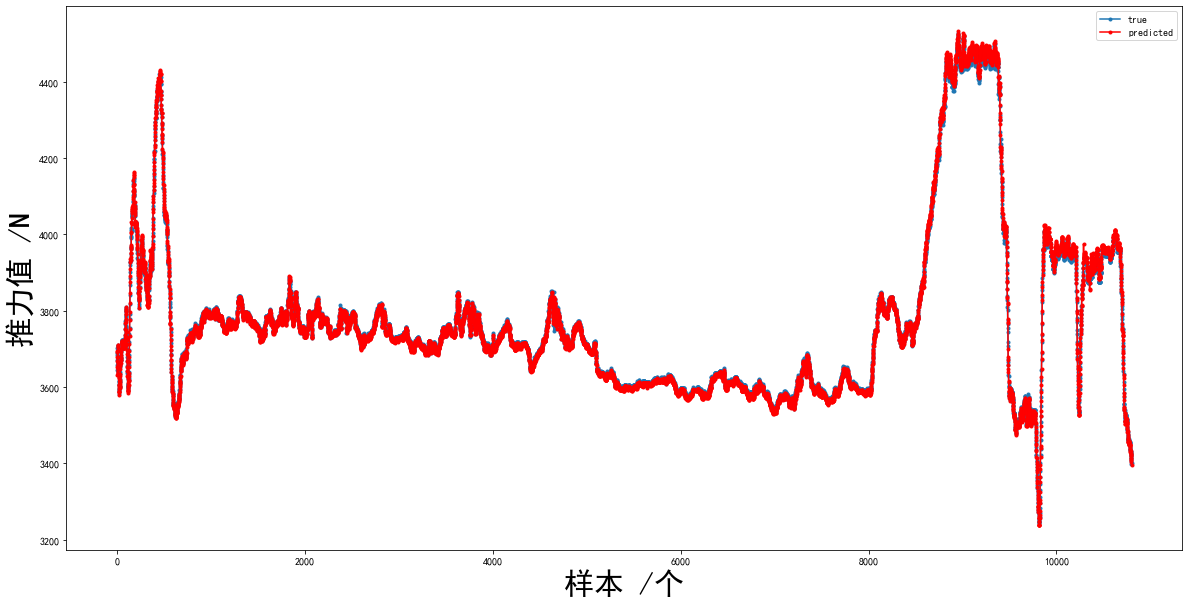

In [39]:
plt.figure(figsize=(20,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.xlabel('样本 /个',fontdict={ 'size'   : 30})
plt.ylabel('推力值 /N',fontdict={ 'size'   : 30})
plt.plot(trainY_1[200:11000],marker='.',label='true')
plt.plot(predict_1[200:11000],'r',marker='.',label='predicted')                  #sample的时刻是一致的
plt.legend();